In [1]:
import torch
import torchvision
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.utils import save_image
from torchvision.datasets import MNIST
import os
import torch.nn.functional as F
import numpy as np
import torch.utils.data as Data
from PIL import  Image,ImageDraw
import numpy as np
import random
import cv2
from torchvision import models
from torchsummary import summary

Batch_Size = 50
num_epochs = 200
learning_rate = 1e-5
samples = 20000

data1 = []
data2= []


#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% --  Generate dataset
uframes = []
vidcap = cv2.VideoCapture('images_new_real.avi')
success,image = vidcap.read()
while success:
    uframes.append(image)   
    success,image = vidcap.read()

# cap = cv2.VideoCapture('video_drone_tank.avi')


# ret, frame = cap.read()

# uframes.append(frame)
# flag = 0
# z = 0
# while(z<30):
#     ret, frame = cap.read()
#     #np_frame = cv2.imread('video', frame) # does not work
#     #np_frame = np.asarray(cv2.GetMat(frame)) # does not work
#     #print(np_frame.shape)
#     for a in uframes:
#         if (np.array(a).any() != None):
#             print("a: ",np.shape(a))
#             print("frame: ",np.shape(a))
#             difference = cv2.subtract(np.array(a), np.array(frame))    
#             result = not np.any(difference)
#             #print("inside for")
#             if result is True:
#                 flag = 1
#                 #print("setting flag")
#                 break
#     if(not flag):
#         #print("appending")
#         uframes.append(frame)
#     z+=1

for i,frame in enumerate(uframes):
    uframes[i] = cv2.resize(frame,(100,100))
    
print(np.shape(uframes[0]))

print("length: ",len(uframes))
for i in range(samples):
    data1.append(np.array(np.transpose(np.asarray(uframes[i % len(uframes)]),(2,0,1)),dtype=np.float32))
    data2.append(np.array(np.transpose(np.asarray(uframes[(i+1) % len(uframes)]),(2,0,1)),dtype=np.float32))



#%%%%%%%%%%%%%%%%%%%%%%%%%%% Noisy data
img = Image.new('RGB', (100,100), color = '#9b7653')
# img.paste(im1,(5,75),im1)
# img.paste(im1,(10,55),im1)
# img.paste(im1,(25,50),im1)
# img.paste(im2,(75,5),im2)
# img.paste(im2,(60,30),im2)
# img.paste(im2,(90,20),im2)
# img.paste(im3,(75,60),im3)
# img.paste(im3,(60,80),im3)
im_n = np.reshape(img,(100,100,3))
b = np.asarray(im_n)
b = np.array(b, dtype=np.float32)
b = np.transpose(b,(2,0,1))
b = torch.from_numpy(b)

#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%       

#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% - Data Preparation

y0 = np.asarray(data1)
y1 = np.asarray(data2)

#y0 = np.array(np.transpose(np.asarray(y0),(0,3,1,2)),dtype=np.float32)
#y1 = np.array(np.transpose(np.asarray(y1),(0,3,1,2)),dtype=np.float32)
print(np.shape(y0))

x = torch.from_numpy(y0)
y = torch.from_numpy(y1)


torch_dataset = Data.TensorDataset(x,y)


loader = Data.DataLoader(

    dataset=torch_dataset,

    batch_size=Batch_Size,

    shuffle=True,

    num_workers=0,

)


#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% - Defining NN

class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()

        # Convolution 1
        self.cnn1 = nn.Conv2d(in_channels=3, out_channels=128, kernel_size=10, stride=1)
        self.relu1 = nn.ReLU()

        # Max pool 1
        self.maxpool1 = nn.MaxPool2d(kernel_size=5)

#         # Convolution 2
#         self.cnn2 = nn.Conv2d(in_channels=16, out_channels=3, kernel_size=5, stride=1, padding=2)
#         self.relu2 = nn.ReLU()

#         # Max pool 2
#         self.maxpool2 = nn.MaxPool2d(kernel_size=5)

        # Fully connected 1 (readout)
        self.fc1 = nn.Linear(20736*2, 30)
        self.sigmoid1 = nn.Sigmoid()

    def forward(self, x):
        # Convolution 1
        out = self.cnn1(x)
        out = self.relu1(out)

        # Max pool 1
        out = self.maxpool1(out)

        # Convolution 2 
        #out = self.cnn2(out)
        #out = self.relu2(out)

        # Max pool 2 
        #out = self.maxpool2(out)
        im_out = out
        # Resize
        # Original size: (100, 32, 7, 7)
        # out.size(0): 100
        # New out size: (100, 32*7*7)
        out = out.view(out.size(0), -1)

        # Linear function (readout)
        out = self.fc1(out)
        out = self.sigmoid1(out)
        return im_out,out
    
model = CNNModel()

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% - Loss Function

def h_score(fx, gy):
 
    fx = fx - fx.mean(0)

    gy = gy - gy.mean(0)

    Nsamples = fx.size(0)
    #print(fx, np.shape(fx))
    #print(gy, np.shape(gy))
    #print(np.shape((torch.transpose(fx,3,2))),np.shape(fx))
    covf = torch.matmul(fx.t(), fx) / Nsamples

    covg = torch.matmul(gy.t(), gy) / Nsamples

    h = -2 * torch.mean((fx * gy).sum(1)) + (covf * covg).sum()

    return h


optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,weight_decay=1e-4)





for epoch in range(num_epochs):
    for x,y in loader:
        optimizer.zero_grad()
        # ===================forward=====================
        #loss = criterion(output1, img)
        loss = h_score(model(x)[1],model(y)[1])
        # ===================backward====================
 
        #optimizer_1.zero_grad()
        loss.backward()
        optimizer.step()
        #optimizer_1.step()
    # ===================log========================
    print('epoch [{}/{}], loss:{:.4f}'.format(epoch+1, num_epochs, loss.item()))
    #print("shape: ", np.shape(model(x[0].reshape(1,3,100, 100))[0]))
#     print("x: ", model(x[0].reshape(1,3,100, 100)))
#     print("y:", model(y[0].reshape(1,3,100, 100)))
#     print("b:", model(b.reshape(1,3,100, 100)))


(100, 100, 3)
length:  1549
(20000, 3, 100, 100)
epoch [1/200], loss:-3.1388
epoch [2/200], loss:-3.1941
epoch [3/200], loss:-3.3065
epoch [4/200], loss:-3.4562
epoch [5/200], loss:-3.8000
epoch [6/200], loss:-3.9161
epoch [7/200], loss:-3.7803
epoch [8/200], loss:-3.7450
epoch [9/200], loss:-3.7247
epoch [10/200], loss:-3.8057
epoch [11/200], loss:-4.2255
epoch [12/200], loss:-4.0953
epoch [13/200], loss:-4.1734
epoch [14/200], loss:-4.6764
epoch [15/200], loss:-4.5492
epoch [16/200], loss:-4.6986
epoch [17/200], loss:-5.0740
epoch [18/200], loss:-5.7597
epoch [19/200], loss:-6.0496
epoch [20/200], loss:-6.4567
epoch [21/200], loss:-6.6328
epoch [22/200], loss:-7.8083
epoch [23/200], loss:-7.3020
epoch [24/200], loss:-8.0704
epoch [25/200], loss:-7.9596
epoch [26/200], loss:-8.3826
epoch [27/200], loss:-8.2435
epoch [28/200], loss:-8.4385
epoch [29/200], loss:-8.8751
epoch [30/200], loss:-9.1504
epoch [31/200], loss:-8.0586
epoch [32/200], loss:-9.0985
epoch [33/200], loss:-8.5140
epo

In [12]:
import sys
np.set_printoptions(threshold=np.inf)
np.set_printoptions(precision=4)
np.set_printoptions(suppress=True)

drone_moving_panels={}
tank_moving_panels={}
tank_reloading_panels={}
drone_reloading_panels={}
tank_firing_panels={}
drone_firing_panels={}

num_channels = 128
buffer = 5

blank_frame = 70
tank_moving = 30
tank_reloading = 35 
tank_firing = 40
drone_moving = 95
drone_reloading = 100 
drone_firing = 105
Tank_moving_Drone_moving = 0
Tank_reloading_Drone_moving = 110
Tank_firing_Drone_moving = 115
Tank_moving_Drone_reloading = 45
Tank_reloading_Drone_reloading = 10
Tank_firing_Drone_reloading = 120
Tank_moving_Drone_firing = 50
Tank_reloading_Drone_firing = 55
Tank_firing_Drone_firing = 15

def val_pos(array):
    value = np.sum(array)
    position = np.unravel_index(np.argmax(array),array.shape)
    return value,position

def image_to_numpy(img):
    data3=[]
    data3.append(np.array(np.transpose(np.asarray(img),(2,0,1)),dtype=np.float32))
    y3 = np.array(data3)
    x_1 = torch.from_numpy(y3)
    output = model(x_1[0].reshape(1,3,100, 100))[0].detach().numpy()
    return output


for i in range(num_channels):

    output = image_to_numpy(uframes[blank_frame])
    blank_panel = output[0][i]
    val_blank,pos_blank = val_pos(blank_panel)
    print("Blank: ",val_blank,pos_blank)
    print("**********")
    
    output = image_to_numpy(uframes[tank_moving])
    tank_moving_panel = output[0][i]
    val_tank_moving,pos_tank_moving = val_pos(tank_moving_panel)
    print("Tank Moving Panel: ",val_tank_moving,pos_tank_moving)
    print("**********")
    
    output = image_to_numpy(uframes[tank_reloading])
    tank_reloading_panel = output[0][i]
    val_tank_reloading,pos_tank_reloading = val_pos(tank_reloading_panel)
    print("Tank Reloading Panel: ",val_tank_reloading,pos_tank_reloading)
    print("**********")
    
    output = image_to_numpy(uframes[tank_firing])
    tank_firing_panel = output[0][i]
    val_tank_firing,pos_tank_firing = val_pos(tank_firing_panel)
    print("Tank firing Panel: ",val_tank_firing,pos_tank_firing)
    print("**********")
    
    output = image_to_numpy(uframes[drone_moving])
    drone_moving_panel = output[0][i]
    val_drone_moving,pos_drone_moving = val_pos(drone_moving_panel)
    print("Drone Moving Panel: ",val_drone_moving,pos_drone_moving)
    print("**********")
    
    output = image_to_numpy(uframes[drone_reloading])
    drone_reloading_panel = output[0][i]
    val_drone_reloading,pos_drone_reloading = val_pos(drone_reloading_panel)
    print("Drone Reloading Panel: ",val_drone_reloading,pos_drone_reloading)
    print("**********")
    
    output = image_to_numpy(uframes[drone_firing])
    drone_firing_panel = output[0][i]
    val_drone_firing,pos_drone_firing = val_pos(drone_firing_panel)
    print("Drone firing Panel: ",val_drone_firing,pos_drone_firing)
    print("**********")
    
    output = image_to_numpy(uframes[Tank_moving_Drone_moving])
    Tank_moving_Drone_moving_panel = output[0][i]
    val_Tank_moving_Drone_moving,pos_Tank_moving_Drone_moving = val_pos(Tank_moving_Drone_moving_panel)
    print("Tank_moving,Drone_moving Panel: ",val_Tank_moving_Drone_moving,pos_Tank_moving_Drone_moving)
    print("**********")
    
    output = image_to_numpy(uframes[Tank_reloading_Drone_moving])
    Tank_reloading_Drone_moving_panel = output[0][i]
    val_Tank_reloading_Drone_moving,pos_Tank_reloading_Drone_moving = val_pos(Tank_reloading_Drone_moving_panel)
    print("Tank_reloading_Drone_moving Panel: ",val_Tank_reloading_Drone_moving,pos_Tank_reloading_Drone_moving)
    print("**********")
    
    output = image_to_numpy(uframes[Tank_firing_Drone_moving])
    Tank_firing_Drone_moving_panel = output[0][i]
    val_Tank_firing_Drone_moving,pos_Tank_firing_Drone_moving = val_pos(Tank_firing_Drone_moving_panel)
    print("Tank_firing_Drone_moving Panel: ",val_Tank_firing_Drone_moving,pos_Tank_firing_Drone_moving)
    print("**********")
    
    output = image_to_numpy(uframes[Tank_moving_Drone_reloading])
    Tank_moving_Drone_reloading_panel = output[0][i]
    val_Tank_moving_Drone_reloading,pos_Tank_moving_Drone_reloading = val_pos(Tank_moving_Drone_reloading_panel)
    print("Tank_moving_Drone_reloading Panel: ",val_Tank_moving_Drone_reloading,pos_Tank_moving_Drone_reloading)
    print("**********")
    
    output = image_to_numpy(uframes[Tank_reloading_Drone_reloading])
    Tank_reloading_Drone_reloading_panel = output[0][i]
    val_Tank_reloading_Drone_reloading,pos_Tank_reloading_Drone_reloading = val_pos(Tank_reloading_Drone_reloading_panel)
    print("Tank_reloading_Drone_reloading Panel: ",val_Tank_reloading_Drone_reloading,pos_Tank_reloading_Drone_reloading)
    print("**********")
    
    output = image_to_numpy(uframes[Tank_firing_Drone_reloading])
    Tank_firing_Drone_reloading_panel = output[0][i]
    val_Tank_firing_Drone_reloading,pos_Tank_firing_Drone_reloading = val_pos(Tank_firing_Drone_reloading_panel)
    print("Tank_firing_Drone_reloading Panel: ",val_Tank_firing_Drone_reloading,pos_Tank_firing_Drone_reloading)
    print("**********")
    
    output = image_to_numpy(uframes[Tank_moving_Drone_firing])
    Tank_moving_Drone_firing_panel = output[0][i]
    val_Tank_moving_Drone_firing,pos_Tank_moving_Drone_firing = val_pos(Tank_moving_Drone_firing_panel)
    print("Tank_moving_Drone_firing Panel: ",val_Tank_moving_Drone_firing,pos_Tank_moving_Drone_firing)
    print("**********")
    
    output = image_to_numpy(uframes[Tank_reloading_Drone_firing])
    Tank_reloading_Drone_firing_panel = output[0][i]
    val_Tank_reloading_Drone_firing,pos_Tank_reloading_Drone_firing = val_pos(Tank_reloading_Drone_firing_panel)
    print("Tank_reloading_Drone_firing Panel: ",val_Tank_reloading_Drone_firing,pos_Tank_reloading_Drone_firing)
    print("**********")
    
    output = image_to_numpy(uframes[Tank_firing_Drone_firing])
    Tank_firing_Drone_firing_panel = output[0][i]
    val_Tank_firing_Drone_firing,pos_Tank_firing_Drone_firing = val_pos(Tank_firing_Drone_firing_panel)
    print("Tank_firing_Drone_firing Panel: ",val_Tank_firing_Drone_firing,pos_Tank_firing_Drone_firing)
    print("**********")

    
    
    print("\nPanel ",i)
    print("\n++++++++++++++++++++++++++++++++++++++++++++\n")
    
    if val_tank_moving > max(val_tank_reloading,val_tank_firing,val_drone_moving,val_drone_reloading,val_drone_firing):
        tank_moving_panels[i] = val_tank_moving - buffer
    
    elif val_drone_moving > max(val_tank_reloading,val_tank_firing,val_tank_moving,val_drone_reloading,val_drone_firing):
        drone_moving_panels[i] = val_drone_moving - buffer
    
    elif val_tank_reloading > max(val_tank_moving,val_tank_firing,val_drone_moving,val_drone_reloading,val_drone_firing):
        tank_reloading_panels[i] = val_tank_reloading - buffer
    
   
    elif val_tank_firing > max(val_tank_reloading,val_tank_moving,val_drone_moving,val_drone_reloading,val_drone_firing):
        tank_firing_panels[i] = val_tank_firing - buffer
    
    elif val_drone_firing > max(val_tank_reloading,val_tank_firing,val_tank_moving,val_drone_reloading,val_drone_moving):
        drone_firing_panels[i] = val_drone_firing - buffer
    
    elif val_drone_reloading > max(val_tank_reloading,val_tank_firing,val_tank_moving,val_drone_moving,val_drone_firing):
        drone_reloading_panels[i] = val_drone_reloading - buffer
    
print("\nTank Moving: \n", tank_moving_panels)
print("\nDrone Moving: \n", drone_moving_panels)
print("\nTank Reloading: \n", tank_reloading_panels)
print("\nDrone Reloading: \n", drone_reloading_panels)
print("\nTank Firing: \n", tank_firing_panels)
print("\nDrone Firing: \n", drone_firing_panels)


Blank:  0.0 (0, 0)
**********
Tank Moving Panel:  262.91086 (6, 6)
**********
Tank Reloading Panel:  44.771755 (6, 6)
**********
Tank firing Panel:  43.539665 (6, 7)
**********
Drone Moving Panel:  23.813368 (13, 10)
**********
Drone Reloading Panel:  125.16379 (12, 15)
**********
Drone firing Panel:  12.179878 (9, 14)
**********
Tank_moving,Drone_moving Panel:  258.4795 (6, 1)
**********
Tank_reloading_Drone_moving Panel:  52.393486 (6, 14)
**********
Tank_firing_Drone_moving Panel:  79.249306 (6, 14)
**********
Tank_moving_Drone_reloading Panel:  394.05554 (6, 7)
**********
Tank_reloading_Drone_reloading Panel:  268.03873 (12, 12)
**********
Tank_firing_Drone_reloading Panel:  325.40292 (12, 0)
**********
Tank_moving_Drone_firing Panel:  330.96686 (6, 8)
**********
Tank_reloading_Drone_firing Panel:  85.82257 (6, 9)
**********
Tank_firing_Drone_firing Panel:  90.73752 (6, 3)
**********

Panel  0

++++++++++++++++++++++++++++++++++++++++++++

Blank:  59.833817 (11, 3)
**********
Tank 

Drone Moving Panel:  281.41904 (13, 9)
**********
Drone Reloading Panel:  165.49641 (13, 17)
**********
Drone firing Panel:  132.29129 (10, 13)
**********
Tank_moving,Drone_moving Panel:  394.69608 (13, 3)
**********
Tank_reloading_Drone_moving Panel:  762.61334 (8, 9)
**********
Tank_firing_Drone_moving Panel:  417.8807 (9, 4)
**********
Tank_moving_Drone_reloading Panel:  182.4811 (11, 2)
**********
Tank_reloading_Drone_reloading Panel:  389.58414 (11, 13)
**********
Tank_firing_Drone_reloading Panel:  248.11136 (11, 2)
**********
Tank_moving_Drone_firing Panel:  311.67676 (6, 9)
**********
Tank_reloading_Drone_firing Panel:  439.58646 (7, 8)
**********
Tank_firing_Drone_firing Panel:  207.63812 (11, 14)
**********

Panel  9

++++++++++++++++++++++++++++++++++++++++++++

Blank:  0.0 (0, 0)
**********
Tank Moving Panel:  211.94527 (5, 6)
**********
Tank Reloading Panel:  40.835686 (5, 8)
**********
Tank firing Panel:  88.28515 (6, 9)
**********
Drone Moving Panel:  100.73028 (12, 12)


Drone firing Panel:  109.3186 (10, 15)
**********
Tank_moving,Drone_moving Panel:  235.19717 (6, 2)
**********
Tank_reloading_Drone_moving Panel:  166.86862 (11, 11)
**********
Tank_firing_Drone_moving Panel:  108.64724 (10, 3)
**********
Tank_moving_Drone_reloading Panel:  324.72327 (11, 1)
**********
Tank_reloading_Drone_reloading Panel:  265.1538 (13, 15)
**********
Tank_firing_Drone_reloading Panel:  200.22281 (12, 1)
**********
Tank_moving_Drone_firing Panel:  184.22418 (13, 3)
**********
Tank_reloading_Drone_firing Panel:  160.62158 (13, 9)
**********
Tank_firing_Drone_firing Panel:  63.68147 (11, 16)
**********

Panel  18

++++++++++++++++++++++++++++++++++++++++++++

Blank:  143.25323 (11, 2)
**********
Tank Moving Panel:  482.5463 (5, 6)
**********
Tank Reloading Panel:  267.6169 (11, 2)
**********
Tank firing Panel:  409.46432 (5, 7)
**********
Drone Moving Panel:  397.4193 (12, 10)
**********
Drone Reloading Panel:  653.97754 (12, 15)
**********
Drone firing Panel:  487.0322

Tank firing Panel:  192.74373 (5, 5)
**********
Drone Moving Panel:  314.4978 (13, 10)
**********
Drone Reloading Panel:  94.22757 (12, 17)
**********
Drone firing Panel:  200.98291 (9, 12)
**********
Tank_moving,Drone_moving Panel:  324.18475 (13, 3)
**********
Tank_reloading_Drone_moving Panel:  483.3789 (10, 12)
**********
Tank_firing_Drone_moving Panel:  481.63412 (9, 5)
**********
Tank_moving_Drone_reloading Panel:  192.74783 (9, 2)
**********
Tank_reloading_Drone_reloading Panel:  259.28418 (5, 4)
**********
Tank_firing_Drone_reloading Panel:  213.5778 (5, 13)
**********
Tank_moving_Drone_firing Panel:  228.41884 (12, 4)
**********
Tank_reloading_Drone_firing Panel:  450.39294 (13, 7)
**********
Tank_firing_Drone_firing Panel:  382.02557 (5, 1)
**********

Panel  27

++++++++++++++++++++++++++++++++++++++++++++

Blank:  176.9925 (15, 15)
**********
Tank Moving Panel:  421.77393 (7, 6)
**********
Tank Reloading Panel:  391.20618 (6, 10)
**********
Tank firing Panel:  481.17712 (7,

Tank_reloading_Drone_moving Panel:  47.26241 (6, 14)
**********
Tank_firing_Drone_moving Panel:  24.756678 (5, 14)
**********
Tank_moving_Drone_reloading Panel:  53.416027 (6, 8)
**********
Tank_reloading_Drone_reloading Panel:  49.6982 (12, 12)
**********
Tank_firing_Drone_reloading Panel:  75.122856 (11, 1)
**********
Tank_moving_Drone_firing Panel:  64.14052 (5, 8)
**********
Tank_reloading_Drone_firing Panel:  50.584084 (6, 9)
**********
Tank_firing_Drone_firing Panel:  32.200912 (5, 3)
**********

Panel  36

++++++++++++++++++++++++++++++++++++++++++++

Blank:  372.07684 (1, 0)
**********
Tank Moving Panel:  546.7466 (5, 4)
**********
Tank Reloading Panel:  694.57806 (6, 6)
**********
Tank firing Panel:  613.3172 (6, 7)
**********
Drone Moving Panel:  849.50635 (13, 9)
**********
Drone Reloading Panel:  676.9894 (13, 16)
**********
Drone firing Panel:  727.9378 (10, 16)
**********
Tank_moving,Drone_moving Panel:  1013.6546 (13, 3)
**********
Tank_reloading_Drone_moving Panel:  116

Tank_moving_Drone_firing Panel:  669.85547 (13, 4)
**********
Tank_reloading_Drone_firing Panel:  778.2853 (12, 9)
**********
Tank_firing_Drone_firing Panel:  634.1902 (10, 16)
**********

Panel  45

++++++++++++++++++++++++++++++++++++++++++++

Blank:  125.125084 (15, 14)
**********
Tank Moving Panel:  442.0998 (7, 4)
**********
Tank Reloading Panel:  250.02704 (5, 8)
**********
Tank firing Panel:  438.3792 (5, 8)
**********
Drone Moving Panel:  369.74866 (13, 11)
**********
Drone Reloading Panel:  526.6318 (12, 16)
**********
Drone firing Panel:  464.54285 (11, 16)
**********
Tank_moving,Drone_moving Panel:  568.2003 (13, 3)
**********
Tank_reloading_Drone_moving Panel:  477.35663 (9, 11)
**********
Tank_firing_Drone_moving Panel:  612.69794 (9, 5)
**********
Tank_moving_Drone_reloading Panel:  1027.1315 (11, 3)
**********
Tank_reloading_Drone_reloading Panel:  815.91364 (12, 12)
**********
Tank_firing_Drone_reloading Panel:  744.00836 (11, 3)
**********
Tank_moving_Drone_firing Pane

Drone Moving Panel:  313.08243 (14, 10)
**********
Drone Reloading Panel:  176.56827 (12, 16)
**********
Drone firing Panel:  185.25124 (10, 13)
**********
Tank_moving,Drone_moving Panel:  379.35913 (14, 2)
**********
Tank_reloading_Drone_moving Panel:  583.4015 (8, 9)
**********
Tank_firing_Drone_moving Panel:  385.48712 (11, 4)
**********
Tank_moving_Drone_reloading Panel:  237.70145 (6, 7)
**********
Tank_reloading_Drone_reloading Panel:  472.6831 (11, 13)
**********
Tank_firing_Drone_reloading Panel:  277.97592 (11, 2)
**********
Tank_moving_Drone_firing Panel:  223.62656 (11, 3)
**********
Tank_reloading_Drone_firing Panel:  422.60516 (6, 10)
**********
Tank_firing_Drone_firing Panel:  119.31408 (6, 3)
**********

Panel  54

++++++++++++++++++++++++++++++++++++++++++++

Blank:  15.646035 (11, 12)
**********
Tank Moving Panel:  102.789185 (5, 7)
**********
Tank Reloading Panel:  191.387 (6, 7)
**********
Tank firing Panel:  119.715965 (6, 7)
**********
Drone Moving Panel:  135.4807

Drone Moving Panel:  508.1774 (13, 11)
**********
Drone Reloading Panel:  272.62863 (14, 17)
**********
Drone firing Panel:  184.20926 (10, 12)
**********
Tank_moving,Drone_moving Panel:  605.7271 (13, 3)
**********
Tank_reloading_Drone_moving Panel:  820.9654 (10, 9)
**********
Tank_firing_Drone_moving Panel:  504.32965 (10, 4)
**********
Tank_moving_Drone_reloading Panel:  494.72827 (11, 2)
**********
Tank_reloading_Drone_reloading Panel:  645.83984 (6, 4)
**********
Tank_firing_Drone_reloading Panel:  349.4431 (12, 2)
**********
Tank_moving_Drone_firing Panel:  429.4129 (7, 9)
**********
Tank_reloading_Drone_firing Panel:  432.42252 (6, 10)
**********
Tank_firing_Drone_firing Panel:  171.18987 (11, 16)
**********

Panel  63

++++++++++++++++++++++++++++++++++++++++++++

Blank:  5.8860087 (11, 12)
**********
Tank Moving Panel:  205.44162 (6, 4)
**********
Tank Reloading Panel:  48.46701 (6, 5)
**********
Tank firing Panel:  82.04788 (6, 6)
**********
Drone Moving Panel:  110.118034 (

Tank_moving,Drone_moving Panel:  331.47372 (6, 0)
**********
Tank_reloading_Drone_moving Panel:  47.488724 (9, 10)
**********
Tank_firing_Drone_moving Panel:  81.12488 (9, 2)
**********
Tank_moving_Drone_reloading Panel:  626.3347 (10, 3)
**********
Tank_reloading_Drone_reloading Panel:  444.45322 (13, 14)
**********
Tank_firing_Drone_reloading Panel:  407.09357 (13, 2)
**********
Tank_moving_Drone_firing Panel:  341.58133 (6, 7)
**********
Tank_reloading_Drone_firing Panel:  60.74982 (11, 10)
**********
Tank_firing_Drone_firing Panel:  62.97837 (6, 2)
**********

Panel  72

++++++++++++++++++++++++++++++++++++++++++++

Blank:  30.124817 (8, 10)
**********
Tank Moving Panel:  219.39706 (7, 8)
**********
Tank Reloading Panel:  131.12021 (6, 9)
**********
Tank firing Panel:  218.38597 (7, 9)
**********
Drone Moving Panel:  193.32797 (12, 10)
**********
Drone Reloading Panel:  418.77576 (13, 15)
**********
Drone firing Panel:  300.15103 (10, 16)
**********
Tank_moving,Drone_moving Panel: 

Tank_firing_Drone_firing Panel:  326.4875 (5, 4)
**********

Panel  81

++++++++++++++++++++++++++++++++++++++++++++

Blank:  53.35996 (10, 12)
**********
Tank Moving Panel:  211.54834 (5, 4)
**********
Tank Reloading Panel:  182.22055 (6, 5)
**********
Tank firing Panel:  221.34001 (6, 6)
**********
Drone Moving Panel:  153.1727 (13, 10)
**********
Drone Reloading Panel:  190.59856 (13, 16)
**********
Drone firing Panel:  113.30303 (10, 15)
**********
Tank_moving,Drone_moving Panel:  300.23157 (6, 0)
**********
Tank_reloading_Drone_moving Panel:  270.85126 (6, 13)
**********
Tank_firing_Drone_moving Panel:  263.8897 (6, 14)
**********
Tank_moving_Drone_reloading Panel:  429.6134 (10, 3)
**********
Tank_reloading_Drone_reloading Panel:  378.0432 (12, 13)
**********
Tank_firing_Drone_reloading Panel:  332.1548 (12, 2)
**********
Tank_moving_Drone_firing Panel:  388.425 (13, 4)
**********
Tank_reloading_Drone_firing Panel:  404.80243 (6, 8)
**********
Tank_firing_Drone_firing Panel:  404

Tank_reloading_Drone_reloading Panel:  557.83386 (13, 13)
**********
Tank_firing_Drone_reloading Panel:  545.00104 (11, 1)
**********
Tank_moving_Drone_firing Panel:  422.8008 (5, 9)
**********
Tank_reloading_Drone_firing Panel:  587.882 (7, 10)
**********
Tank_firing_Drone_firing Panel:  376.1576 (11, 17)
**********

Panel  90

++++++++++++++++++++++++++++++++++++++++++++

Blank:  0.0 (0, 0)
**********
Tank Moving Panel:  173.07579 (6, 5)
**********
Tank Reloading Panel:  126.44261 (6, 6)
**********
Tank firing Panel:  184.12285 (6, 6)
**********
Drone Moving Panel:  23.672926 (13, 10)
**********
Drone Reloading Panel:  86.9333 (12, 17)
**********
Drone firing Panel:  115.02887 (10, 13)
**********
Tank_moving,Drone_moving Panel:  228.41245 (6, 1)
**********
Tank_reloading_Drone_moving Panel:  116.57151 (6, 13)
**********
Tank_firing_Drone_moving Panel:  195.17369 (6, 14)
**********
Tank_moving_Drone_reloading Panel:  242.02258 (6, 7)
**********
Tank_reloading_Drone_reloading Panel:  1

Tank firing Panel:  227.11998 (6, 5)
**********
Drone Moving Panel:  221.77393 (12, 10)
**********
Drone Reloading Panel:  420.49414 (13, 16)
**********
Drone firing Panel:  214.48045 (9, 14)
**********
Tank_moving,Drone_moving Panel:  499.30414 (12, 2)
**********
Tank_reloading_Drone_moving Panel:  351.48495 (6, 12)
**********
Tank_firing_Drone_moving Panel:  352.18094 (9, 4)
**********
Tank_moving_Drone_reloading Panel:  823.82117 (10, 2)
**********
Tank_reloading_Drone_reloading Panel:  625.2987 (12, 13)
**********
Tank_firing_Drone_reloading Panel:  750.96014 (12, 2)
**********
Tank_moving_Drone_firing Panel:  558.4943 (5, 9)
**********
Tank_reloading_Drone_firing Panel:  429.01987 (6, 7)
**********
Tank_firing_Drone_firing Panel:  359.6324 (6, 2)
**********

Panel  100

++++++++++++++++++++++++++++++++++++++++++++

Blank:  0.0 (0, 0)
**********
Tank Moving Panel:  165.80585 (5, 7)
**********
Tank Reloading Panel:  26.589146 (6, 8)
**********
Tank firing Panel:  30.62888 (5, 8)
***

Tank_reloading_Drone_firing Panel:  291.63693 (7, 8)
**********
Tank_firing_Drone_firing Panel:  212.56117 (5, 2)
**********

Panel  109

++++++++++++++++++++++++++++++++++++++++++++

Blank:  16.37165 (12, 12)
**********
Tank Moving Panel:  106.65192 (6, 7)
**********
Tank Reloading Panel:  167.32607 (6, 5)
**********
Tank firing Panel:  110.868675 (6, 6)
**********
Drone Moving Panel:  197.30974 (12, 11)
**********
Drone Reloading Panel:  180.8635 (14, 16)
**********
Drone firing Panel:  198.06793 (10, 12)
**********
Tank_moving,Drone_moving Panel:  270.2162 (12, 2)
**********
Tank_reloading_Drone_moving Panel:  329.39783 (9, 8)
**********
Tank_firing_Drone_moving Panel:  279.03885 (9, 3)
**********
Tank_moving_Drone_reloading Panel:  251.24251 (11, 2)
**********
Tank_reloading_Drone_reloading Panel:  306.50546 (14, 14)
**********
Tank_firing_Drone_reloading Panel:  336.69067 (12, 0)
**********
Tank_moving_Drone_firing Panel:  381.73438 (13, 2)
**********
Tank_reloading_Drone_firing P

Drone firing Panel:  185.07878 (11, 14)
**********
Tank_moving,Drone_moving Panel:  142.8994 (6, 0)
**********
Tank_reloading_Drone_moving Panel:  272.60815 (6, 14)
**********
Tank_firing_Drone_moving Panel:  418.00006 (6, 13)
**********
Tank_moving_Drone_reloading Panel:  120.28882 (6, 6)
**********
Tank_reloading_Drone_reloading Panel:  213.90347 (6, 1)
**********
Tank_firing_Drone_reloading Panel:  300.225 (6, 14)
**********
Tank_moving_Drone_firing Panel:  241.87003 (13, 2)
**********
Tank_reloading_Drone_firing Panel:  250.71832 (6, 8)
**********
Tank_firing_Drone_firing Panel:  436.5606 (11, 14)
**********

Panel  118

++++++++++++++++++++++++++++++++++++++++++++

Blank:  0.0 (0, 0)
**********
Tank Moving Panel:  2.9537005 (6, 5)
**********
Tank Reloading Panel:  267.41608 (6, 7)
**********
Tank firing Panel:  13.085931 (6, 7)
**********
Drone Moving Panel:  162.75772 (13, 11)
**********
Drone Reloading Panel:  61.70803 (12, 15)
**********
Drone firing Panel:  87.20252 (9, 14)
**

Tank_reloading_Drone_firing Panel:  94.38786 (5, 10)
**********
Tank_firing_Drone_firing Panel:  48.68371 (5, 4)
**********

Panel  126

++++++++++++++++++++++++++++++++++++++++++++

Blank:  178.63385 (16, 14)
**********
Tank Moving Panel:  317.92194 (6, 5)
**********
Tank Reloading Panel:  549.87854 (6, 6)
**********
Tank firing Panel:  687.0187 (6, 6)
**********
Drone Moving Panel:  389.14075 (13, 9)
**********
Drone Reloading Panel:  269.67102 (16, 14)
**********
Drone firing Panel:  475.03278 (10, 13)
**********
Tank_moving,Drone_moving Panel:  546.6573 (13, 1)
**********
Tank_reloading_Drone_moving Panel:  664.3513 (6, 12)
**********
Tank_firing_Drone_moving Panel:  752.1325 (6, 14)
**********
Tank_moving_Drone_reloading Panel:  329.97635 (6, 6)
**********
Tank_reloading_Drone_reloading Panel:  641.10626 (6, 3)
**********
Tank_firing_Drone_reloading Panel:  706.0873 (6, 14)
**********
Tank_moving_Drone_firing Panel:  625.5301 (13, 4)
**********
Tank_reloading_Drone_firing Panel:  

In [6]:
for i in range(12):
    img = uframes[i]
    z = Image.fromarray(img)
    z.show()

In [14]:
import sys
np.set_printoptions(threshold=np.inf)
np.set_printoptions(precision=4)
np.set_printoptions(suppress=True)

frames_considered = 130

temp = tank_firing_panels

for j in range(len(list(temp))):
    l = []
    tank_info_panel = list(tank_moving_panels)[0]
    drone_info_panel = list(drone_moving_panels)[0]
    tankr_info_panel = list(tank_reloading_panels)[0]
    droner_info_panel = list(drone_reloading_panels)[0] #38,58
    tankf_info_panel = list(tank_firing_panels)[j]
    dronef_info_panel = list(drone_firing_panels)[0] 


    tank_threshold= tank_moving_panels[tank_info_panel]
    tankr_threshold= tank_reloading_panels[tankr_info_panel]
    tankf_threshold= tank_firing_panels[tankf_info_panel]
    drone_threshold= drone_moving_panels[drone_info_panel]
    droner_threshold= drone_reloading_panels[droner_info_panel]
    dronef_threshold= drone_firing_panels[dronef_info_panel]

    def val_pos(array):
        value = np.sum(array)
        position = np.unravel_index(np.argmax(array),array.shape)
        return value,position
    dronec=[]
    tankc=[]
    tankrc=[]
    dronerc=[]
    tankfc=[]
    dronefc=[]

    for i in range(frames_considered):
        img = uframes[i]
        data3=[]
        data3.append(np.array(np.transpose(np.asarray(img),(2,0,1)),dtype=np.float32))
        y3 = np.array(data3)
        x_1 = torch.from_numpy(y3)
        output = model(x_1.reshape(1,3,100, 100))[0].detach().numpy()
        output_tank = output[0][tank_info_panel]
        output_tankr = output[0][tankr_info_panel]
        output_tankf = output[0][tankf_info_panel]
        output_drone = output[0][drone_info_panel]
        output_droner = output[0][droner_info_panel]
        output_dronef = output[0][dronef_info_panel]

        val_tank,pos_tank = val_pos(output_tank)
        val_tankr,pos_tankr = val_pos(output_tankr)
        val_tankf,pos_tankf = val_pos(output_tankf)
        
        val_drone,pos_drone = val_pos(output_drone)
        val_droner,pos_droner = val_pos(output_droner)
        val_dronef,pos_dronef = val_pos(output_dronef)
        


        if val_tank>tank_threshold:
            #print("tank present")
            tankc.append(pos_tank)
            
            
        if val_tankr>tankr_threshold:
            #print("tank reloading present")
            tankrc.append(pos_tankr)
            
            
        if val_tankf>tankf_threshold:
            #print("tank firing present")
            tankfc.append(pos_tankf)
            l.append(i)
            
            
        
        if val_drone > drone_threshold:
            #print("drone present")
            dronec.append(pos_drone)
            #print(i)
            #l.append(i)
            
        if val_droner>droner_threshold:
            #print("drone reloading present")
            #l.append(i)
            #print(i)
            dronerc.append(pos_droner)
            #l.append(i)
        
        if val_dronef>dronef_threshold:
            #print("drone firing present")
            dronefc.append(pos_dronef)
            #print(i)
            #l.append(i)
        
    print("\n")
    print(list(temp)[j])
    print(l)
    print("+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++\n\n")





15
[0, 1, 3, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 26, 28, 29, 40, 41, 42, 43, 44, 45, 46, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 66, 68, 79, 80, 81, 82, 83, 84, 85, 86, 87, 91, 92, 93, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 129]
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++




20
[8, 11, 14, 15, 16, 17, 18, 19, 40, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 79, 80, 81, 82, 83, 84, 87, 88, 94, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124]
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++




22
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 36, 37, 38, 39, 40, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94

In [15]:
import sys
np.set_printoptions(threshold=np.inf)
np.set_printoptions(precision=4)
np.set_printoptions(suppress=True)

tank_info_panel = 60
drone_info_panel = 80
tankr_info_panel = 34
droner_info_panel = 1
tankf_info_panel = 99
dronef_info_panel = 12


tank_threshold= tank_moving_panels[tank_info_panel]
tankr_threshold= tank_reloading_panels[tankr_info_panel]
tankf_threshold= tank_firing_panels[tankf_info_panel]
drone_threshold= drone_moving_panels[drone_info_panel]
droner_threshold= drone_reloading_panels[droner_info_panel]
dronef_threshold= drone_firing_panels[dronef_info_panel]

def val_pos(array):
    value = np.sum(array)
    position = np.unravel_index(np.argmax(array),array.shape)
    return value,position
dronec=[]
tankc=[]
tankrc=[]
dronerc=[]
tankfc=[]
dronefc=[]

for i in range(frames_considered):
    img = uframes[i]
    data3=[]
    data3.append(np.array(np.transpose(np.asarray(img),(2,0,1)),dtype=np.float32))
    y3 = np.array(data3)
    x_1 = torch.from_numpy(y3)
    output = model(x_1.reshape(1,3,100, 100))[0].detach().numpy()
    output_tank = output[0][tank_info_panel]
    output_tankr = output[0][tankr_info_panel]
    output_tankf = output[0][tankf_info_panel]
    output_drone = output[0][drone_info_panel]
    output_droner = output[0][droner_info_panel]
    output_dronef = output[0][dronef_info_panel]

    val_tank,pos_tank = val_pos(output_tank)
    val_tankr,pos_tankr = val_pos(output_tankr)
    val_tankf,pos_tankf = val_pos(output_tankf)

    val_drone,pos_drone = val_pos(output_drone)
    val_droner,pos_droner = val_pos(output_droner)
    val_dronef,pos_dronef = val_pos(output_dronef)



    if val_tank>tank_threshold:
        #print("tank present")
        tankc.append(pos_tank)


    if val_tankr>tankr_threshold:
        #print("tank reloading present")
        tankrc.append(pos_tankr)


    if val_tankf>tankf_threshold:
        #print("tank firing present")
        tankfc.append(pos_tankf)
        #l.append(i)



    if val_drone > drone_threshold:
        #print("drone present")
        dronec.append(pos_drone)
        #print(i)
        #l.append(i)

    if val_droner>droner_threshold:
        #print("drone reloading present")
        #l.append(i)
        #print(i)
        dronerc.append(pos_droner)
        #l.append(i)

    if val_dronef>dronef_threshold:
        #print("drone firing present")
        dronefc.append(pos_dronef)
        #print(i)
        #l.append(i)




In [64]:
img = uframes[24]
z = Image.fromarray(img)
z.show()

In [3]:
import sys
np.set_printoptions(threshold=np.inf)
np.set_printoptions(precision=4)
np.set_printoptions(suppress=True)


def val_pos(array):
    value = np.sum(array)
    position = np.unravel_index(np.argmax(array),array.shape)
    return value,position

for i in range(32):

    tank_info_panel = i
    drone_info_panel = i
    #Blank
    img = Image.open("spacecraft/0blank.png")
    img =  cv2.resize(np.asarray(img),(100,100))
    #z.show()
    data3=[]
    data3.append(np.array(np.transpose(np.asarray(img),(2,0,1)),dtype=np.float32))
    y3 = np.array(data3)
    x_1 = torch.from_numpy(y3)
    output = model(x_1[0].reshape(1,3,100, 100))[0].detach().numpy()
    output_tank = output[0][tank_info_panel]
    val,pos = val_pos(output_tank)
    print("Blank: ",val,pos)
    output_drone = output[0][drone_info_panel]
    val,pos = val_pos(output_drone)
    print("Blank: ",val,pos)


    
    img = Image.open("spacecraft/0tank.png")
    img =  cv2.resize(np.asarray(img),(100,100))
    data3=[]
    data3.append(np.array(np.transpose(np.asarray(img),(2,0,1)),dtype=np.float32))
    y3 = np.array(data3)
    x_1 = torch.from_numpy(y3)
    output = model(x_1[0].reshape(1,3,100, 100))[0].detach().numpy()
    output_tank = output[0][tank_info_panel]
    val,pos = val_pos(output_tank)
    print("Tank: ",val,pos)
    output_drone = output[0][drone_info_panel]
    val,pos = val_pos(output_drone)
    print("Tank: ",val,pos)


    #Drone

    img = Image.open("spacecraft/0drone.png")
    img =  cv2.resize(np.asarray(img),(100,100))
    data3=[]
    data3.append(np.array(np.transpose(np.asarray(img),(2,0,1)),dtype=np.float32))
    y3 = np.array(data3)
    x_1 = torch.from_numpy(y3)
    output = model(x_1[0].reshape(1,3,100, 100))[0].detach().numpy()
    output_tank = output[0][tank_info_panel]
    val,pos = val_pos(output_tank)
    print("Drone: ",val,pos)
    output_drone = output[0][drone_info_panel]
    val,pos = val_pos(output_drone)
    print("Drone: ",val,pos)
    
        
    img = Image.open("spacecraft/0tank_reloading.png")
    img =  cv2.resize(np.asarray(img),(100,100))
    data3=[]
    data3.append(np.array(np.transpose(np.asarray(img),(2,0,1)),dtype=np.float32))
    y3 = np.array(data3)
    x_1 = torch.from_numpy(y3)
    output = model(x_1[0].reshape(1,3,100, 100))[0].detach().numpy()
    output_tank = output[0][tank_info_panel]
    val,pos = val_pos(output_tank)
    print("Tank reloading: ",val,pos)
    output_drone = output[0][drone_info_panel]
    val,pos = val_pos(output_drone)
    print("Tank reloading: ",val,pos)


    #Drone

    img = Image.open("spacecraft/0drone_reloading.png")
    img =  cv2.resize(np.asarray(img),(100,100))
    data3=[]
    data3.append(np.array(np.transpose(np.asarray(img),(2,0,1)),dtype=np.float32))
    y3 = np.array(data3)
    x_1 = torch.from_numpy(y3)
    output = model(x_1[0].reshape(1,3,100, 100))[0].detach().numpy()
    output_tank = output[0][tank_info_panel]
    val,pos = val_pos(output_tank)
    print("Drone reloading: ",val,pos)
    output_drone = output[0][drone_info_panel]
    val,pos = val_pos(output_drone)
    print("Drone reloading: ",val,pos)


    #Tank and Drone
    img = Image.open("spacecraft/0.png")
    img =  cv2.resize(np.asarray(img),(100,100))
    #z.show()
    data3=[]
    data3.append(np.array(np.transpose(np.asarray(img),(2,0,1)),dtype=np.float32))
    y3 = np.array(data3)
    x_1 = torch.from_numpy(y3)
    output = model(x_1[0].reshape(1,3,100, 100))[0].detach().numpy()
    output_tank = output[0][tank_info_panel]
    val,pos = val_pos(output_tank)
    print("TD: ",val,pos)
    output_drone = output[0][drone_info_panel]
    val,pos = val_pos(output_drone)
    print("TD: ",val,pos)
    
    print("done ",i)
    print("++++++++++++++++++++++++++++++++++++++++++++")

Blank:  385.18863 (10, 3)
Blank:  385.18863 (10, 3)
Tank:  512.6679 (5, 0)
Tank:  512.6679 (5, 0)
Drone:  491.6334 (11, 10)
Drone:  491.6334 (11, 10)
Tank reloading:  535.1559 (6, 1)
Tank reloading:  535.1559 (6, 1)
Drone reloading:  483.6514 (11, 9)
Drone reloading:  483.6514 (11, 9)
TD:  678.0335 (5, 0)
TD:  678.0335 (5, 0)
done  0
++++++++++++++++++++++++++++++++++++++++++++
Blank:  24570.285 (16, 15)
Blank:  24570.285 (16, 15)
Tank:  24819.215 (16, 15)
Tank:  24819.215 (16, 15)
Drone:  24844.879 (11, 9)
Drone:  24844.879 (11, 9)
Tank reloading:  25150.172 (5, 0)
Tank reloading:  25150.172 (5, 0)
Drone reloading:  24756.168 (11, 11)
Drone reloading:  24756.168 (11, 11)
TD:  25126.066 (11, 10)
TD:  25126.066 (11, 10)
done  1
++++++++++++++++++++++++++++++++++++++++++++
Blank:  2405.2634 (3, 8)
Blank:  2405.2634 (3, 8)
Tank:  2718.6584 (6, 1)
Tank:  2718.6584 (6, 1)
Drone:  2748.322 (10, 9)
Drone:  2748.322 (10, 9)
Tank reloading:  2891.2192 (5, 0)
Tank reloading:  2891.2192 (5, 0)
Dr

Tank:  308.02267 (6, 1)
Tank:  308.02267 (6, 1)
Drone:  208.01671 (10, 13)
Drone:  208.01671 (10, 13)
Tank reloading:  226.81674 (5, 0)
Tank reloading:  226.81674 (5, 0)
Drone reloading:  272.68506 (12, 10)
Drone reloading:  272.68506 (12, 10)
TD:  420.11844 (6, 1)
TD:  420.11844 (6, 1)
done  21
++++++++++++++++++++++++++++++++++++++++++++
Blank:  53.2502 (10, 12)
Blank:  53.2502 (10, 12)
Tank:  174.52512 (5, 0)
Tank:  174.52512 (5, 0)
Drone:  124.26646 (10, 10)
Drone:  124.26646 (10, 10)
Tank reloading:  107.94854 (5, 2)
Tank reloading:  107.94854 (5, 2)
Drone reloading:  197.1109 (10, 9)
Drone reloading:  197.1109 (10, 9)
TD:  399.3283 (10, 10)
TD:  399.3283 (10, 10)
done  22
++++++++++++++++++++++++++++++++++++++++++++
Blank:  1082.6456 (2, 8)
Blank:  1082.6456 (2, 8)
Tank:  1325.901 (5, 1)
Tank:  1325.901 (5, 1)
Drone:  1374.3658 (10, 9)
Drone:  1374.3658 (10, 9)
Tank reloading:  1401.387 (5, 0)
Tank reloading:  1401.387 (5, 0)
Drone reloading:  1286.0583 (11, 9)
Drone reloading:  

In [33]:
import sys
np.set_printoptions(threshold=np.inf)
np.set_printoptions(precision=4)
np.set_printoptions(suppress=True)

tank_info_panel = 4
drone_info_panel = 24

def val_pos(array):
    value = np.sum(array)
    position = np.unravel_index(np.argmax(array),array.shape)
    return value,position

#Blank
for i in range(12):
    img = uframes[i]
    z = Image.fromarray(img)
    #z.show()
    data3=[]
    data3.append(np.array(np.transpose(np.asarray(img),(2,0,1)),dtype=np.float32))
    y3 = np.array(data3)
    x_1 = torch.from_numpy(y3)
    output = model(x_1[0].reshape(1,3,100, 100))[0].detach().numpy()
    output_tank = output[0][tank_info_panel]
    val_tank,pos_tank = val_pos(output_tank)
    print(i)
    output_drone = output[0][drone_info_panel]
    val_drone,pos_drone = val_pos(output_drone)
    if val_tank>500:
        print("tank present")
        print("Tank info: ",val_tank,pos_tank)
    if val_drone>770:
        print("drone present")
        print("Drone info: ",val_drone,pos_drone)

0
1
tank present
Tank info:  520.7602 (6, 2)
2
drone present
Drone info:  781.4645 (1, 4)
3
tank present
Tank info:  634.67224 (6, 2)
drone present
Drone info:  942.7866 (1, 4)
4
tank present
Tank info:  654.7293 (6, 8)
drone present
Drone info:  927.96313 (1, 4)
5
tank present
Tank info:  642.7981 (6, 13)
drone present
Drone info:  985.1527 (1, 4)
6
tank present
Tank info:  722.30286 (6, 2)
drone present
Drone info:  938.44824 (5, 1)
7
tank present
Tank info:  740.57965 (6, 8)
drone present
Drone info:  860.5968 (5, 7)
8
tank present
Tank info:  730.4288 (6, 13)
drone present
Drone info:  976.33765 (5, 12)
9
tank present
Tank info:  669.9697 (6, 2)
drone present
Drone info:  1017.36505 (13, 15)
10
tank present
Tank info:  690.02686 (6, 8)
drone present
Drone info:  1002.5415 (13, 15)
11
tank present
Tank info:  678.09564 (6, 13)
drone present
Drone info:  1059.7312 (13, 15)


In [15]:
im1 = Image.open('tree1.png')
im1 = im1.resize((100,100))

imt = Image.open('tank.png')
imt = imt.resize((100,100))


im2 = Image.open('tree2.png')
im2 = im2.resize((100,100))

im3 = Image.open('tree3.png')
im3 = im3.resize((100,100))

im_drone = Image.open('drone4-1.png')
im_drone = im_drone.resize((200,200))

imb = Image.open('bullet.png')
imb = imb.resize((40,40))



img_blank = Image.new('RGB', (720, 1080), color = '#9b7653')
img_blank.paste(im1,(5,75),im1)
img_blank.paste(im1,(450,550),im1)
img_blank.paste(im1,(205,720),im1)
img_blank.paste(im2,(500,900),im2)
img_blank.paste(im2,(650,750),im2)
img_blank.paste(im2,(320,440),im2)
img_blank.paste(im3,(100,600),im3)
img_blank.paste(im3,(440,620),im3)
img_blank.paste(im3,(300,150),im3)
img_blank.paste(imt.rotate(180),(500,500),imt.rotate(180))
img_blank = np.asarray(img_blank)
img_blank = cv2.resize(img_blank,(100,100))
pil = np.array(np.transpose(np.asarray(img_blank),(2,0,1)),dtype=np.float32)
pil = torch.from_numpy(pil)
output = model(pil.reshape(1,3,100, 100))[0].detach().numpy()
output = output[0][info_panel]
val,pos = val_pos(output)
print(val,pos)

NameError: name 'info_panel' is not defined

In [3]:
import sys
np.set_printoptions(threshold=np.inf)
np.set_printoptions(precision=4)
np.set_printoptions(suppress=True)

for i in range(12):
    k = uframes[i]
    #k.show()
    v = np.array(np.transpose(np.asarray(uframes[i]),(2,0,1)),dtype=np.float32)
    v = torch.from_numpy(v)
    filename = "Marginalization_Simple-increased_channels-32/ref_image_new_" + str(i) + ".txt"
    file = open(filename, 'w')
    file.write(str(model(v.reshape(1,3,100, 100))[0].detach().numpy()))
    file.close()


In [4]:
import sys
np.set_printoptions(threshold=np.inf)
np.set_printoptions(precision=4)
np.set_printoptions(suppress=True)

filename = "Marginalization_Simple-increased_channels-32/fc_weights.txt"
file = open(filename, 'w')
file.write(str(model.fc1.weight.detach().numpy()))
print(np.shape(model.fc1.weight.detach().numpy()))
file.close()


(15, 10368)


In [5]:
import sys
np.set_printoptions(threshold=np.inf)
np.set_printoptions(precision=4)
np.set_printoptions(suppress=True)

for i in range(12):
    img = uframes[i]
    #print(np.shape(img))
    z = Image.fromarray(img)
    z.show()

In [6]:
import operator
import sys
#t1d1
img_blank = Image.new('RGB', (100, 100), color = '#9b7653')
img_blank.paste(imt.rotate(180),(10,30),imt.rotate(180))
# img_blank.paste(im_drone.resize((10,10)),(2,10),im_drone.resize((10,10)))

# #t2d2
# img_blank.paste(imt.rotate(180),(30,30),imt.rotate(180))
# draw = ImageDraw.Draw(img_blank)
# draw.ellipse((35,35,38,38), fill=(255, 0, 0))
# img_blank.paste(im_drone.resize((10,10)),(35,45),im_drone.resize((10,10)))
# draw.ellipse((40,50,43,53), fill=(50, 182, 150))

# #t3d3
# img_blank.paste(imt.rotate(180),(50,30),imt.rotate(180))
# img_blank.paste(imb.resize((2,2)),(54,40),imb.resize((2,2)))
# img_blank.paste(im_drone.resize((10,10)),(50,70),im_drone.resize((10,10)))
# img_blank.paste(imb.resize((2,2)),(56,81),imb.resize((2,2)))

v = np.array(np.transpose(np.asarray(img_blank),(2,0,1)),dtype=np.float32)
v = torch.from_numpy(v)
k = model(v.reshape(1,3,100, 100))[0].view(model(v.reshape(1,3,100, 100))[0].size(0), -1).detach().numpy()

filename = "Marginalization_Simple/flattened_tank_pos_1.txt"
file = open(filename, 'w')
file.write(str(k))
file.close()


# print(np.shape(k))
# index, value = max(enumerate(k), key=operator.itemgetter(1))
# print(index,value)


import operator
p=model.fc1.weight.detach().numpy()
for i in range(15):
    index, value = max(enumerate(p[i]), key=operator.itemgetter(1))
    print("FC - Feature "+ str(i) +" : ",index,value)
    print
    print("CNN value: ",k[0][index] )

FC - Feature 0 :  684 0.041578084
CNN value:  17.59211
FC - Feature 1 :  684 0.051804464
CNN value:  17.59211
FC - Feature 2 :  360 0.04816093
CNN value:  0.53643996
FC - Feature 3 :  492 0.035558272
CNN value:  0.53643996
FC - Feature 4 :  478 0.06459166
CNN value:  0.53643996
FC - Feature 5 :  585 0.049136233
CNN value:  0.53643996
FC - Feature 6 :  492 0.081621096
CNN value:  0.53643996
FC - Feature 7 :  360 0.065480515
CNN value:  0.53643996
FC - Feature 8 :  585 0.04792851
CNN value:  0.53643996
FC - Feature 9 :  492 0.06556648
CNN value:  0.53643996
FC - Feature 10 :  684 0.035789683
CNN value:  17.59211
FC - Feature 11 :  684 0.034514345
CNN value:  17.59211
FC - Feature 12 :  817 0.043642323
CNN value:  17.59211
FC - Feature 13 :  492 0.088237286
CNN value:  0.53643996
FC - Feature 14 :  492 0.09752004
CNN value:  0.53643996


In [21]:

import random


p=0
class_data = []
while(p<len(uframes)):
    data3=[]
    print(p)
    for i in range(50):
        img = uframes[p]
        data3.append(np.array(np.transpose(np.asarray(img),(2,0,1)),dtype=np.float32))
        y3 = np.array(data3)
        x_1 = torch.from_numpy(y3)
        temp = model(x_1[i].reshape(1,3,100,100))[1]
        #print(temp)
        class_data.append((list(temp.detach().numpy()[0]),p))
    p+=1
    print(len(class_data))

random.shuffle(class_data)
random.shuffle(class_data)

print("length ", len(class_data))

0
50
1
100
2
150
3
200
4
250
5
300
6
350
7
400
8
450
9
500
10
550
11
600
length  600


In [22]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm, datasets
from colorama import init  
import time
import cv2

print(np.shape(uframes[0]))


#z  = np.array(np.transpose(np.asarray(z),(2,0,1)),dtype=np.float32)
# import some data to play with
print("Length of Class data: ", len(class_data))
# Take the first two features. We could avoid this by using a two-dim dataset
X = [(i[0]) for i in class_data]
y = [i[1] for i in class_data]
#print(X,np.shape(X))
#print(y,np.shape(y))
# we create an instance of SVM and fit out data. We do not scale our
# data since we want to plot the support vectors
C = 1.0  # SVM regularization parameter
clf = svm.SVC(kernel='linear', C=C)
clf = clf.fit(X, y)
data3=[]
y3=0

n1 = "\x1b[31m\"Drone Stationary, Tank Firing\"\x1b[0m"
n2 = "\x1b[31m\"Drone Reloading, Tank Firing\"\x1b[0m"
n3 = "\x1b[31m\"Drone Firing, Tank Stationary\"\x1b[0m"
n4 = "\x1b[31m\"Drone Firing, Tank Reloading\"\x1b[0m"
n5 = "\x1b[31m\"Drone Firing, Tank Firing\"\x1b[0m"

names = ['Just Background','Only Tank moving', 'Only Drone Moving', 'Drone stationary, Tank Stationary', 'Drone Stationary, Tank Reloading' ,
         n1, 'Drone reloading, Tank Stationary', 'Drone reloading, Tank Reloading', n2 , n3,n4,n5]

print("Start")

img_blank = Image.new('RGB', (100, 100), color = '#9b7653')
img_blank.paste(im1,(5,7),im1)
img_blank.paste(im1,(45,55),im1)
img_blank.paste(im1,(25,72),im1)
img_blank.paste(im2,(50,90),im2)
img_blank.paste(im2,(60,75),im2)
img_blank.paste(im2,(30,40),im2)
img_blank.paste(im3,(10,60),im3)
img_blank.paste(im3,(44,62),im3)
img_blank.paste(im3,(30,15),im3)
img_blank.paste(imt.rotate(180),(50,30),imt.rotate(180))
img_blank.paste(imb.resize((2,2)),(54,40),imb.resize((2,2)))
#img_blank.paste(im_drone.resize((10,10)),(50,70),im_drone.resize((10,10)))
#img_blank.paste(imb.resize((2,2)),(56,81),imb.resize((2,2)))

for i in range(12):
    #z = cv2.imread('Images_100/0a.png')
    #l = Image.fromarray(z)
#     print("shape of z", np.shape(z),type(z))
#     #l.show()
#     #z  = cv2.resize(z,(100,100))
#     img = uframes[i]
#     print(np.shape(img))
#     img.show()
#     data3.append(np.array(np.transpose(np.asarray(uframes[i]),(2,0,1)),dtype=np.float32))
#     y3 = np.array(data3)
#     x_1 = torch.from_numpy(y3)
# #     random_img = random.choice(x)
# #     print("random", np.shape(random_img),type(random_img))
# #     show = random_img.detach().numpy() * 255
# #     show = np.array(np.transpose(show,(1,2,0)),dtype=np.uint8)
# #     print("show", np.shape(show),type(show))
# #     ms = Image.fromarray(show)
# #     ms.show()
#     temp = model(x_1[i].reshape(1,3,100,100))[1]
#     temp = temp.detach().numpy()
#     img_blank.show()
#     #print(temp)
#     z = clf.predict(temp)
#     print(names[z[0]])
    img = uframes[i]
    print(np.shape(img))
    img.show()
    #ms = Image.fromarray(z)
    #ms.show()
    data3.append(np.array(np.transpose(np.asarray(img),(2,0,1)),dtype=np.float32))
    y3 = np.array(data3)
    x_1 = torch.from_numpy(y3)
    temp = model(x_1[i].reshape(1,3,100,100))[1]
    temp = temp.detach().numpy()
    print(temp)
    z = clf.predict(temp)
    print(names[z[0]])
    
    

(100, 100, 3)
Length of Class data:  600
Start
(100, 100, 3)
[[5.69654167e-01 9.99462187e-01 5.63863292e-02 4.24214751e-01
  9.99946237e-01 3.76719624e-01 9.24754981e-03 9.96866763e-01
  3.24720666e-02 6.23485744e-01 9.99366581e-01 1.33173708e-05
  9.99919176e-01 1.10880566e-04 7.16020440e-05]]
Just Background
(100, 100, 3)
[[1.0693459e-01 9.7853309e-01 6.2482929e-01 8.8721722e-01 9.2732191e-01
  3.8686104e-04 4.0334295e-03 9.7163016e-01 4.2039016e-01 9.9970645e-01
  9.6105587e-01 4.5536429e-02 9.1955161e-01 2.7226047e-03 7.8407951e-02]]
Only Tank moving
(100, 100, 3)
[[7.3534204e-03 9.9773276e-01 9.8508829e-01 9.9262118e-01 4.5104271e-01
  3.5262175e-04 1.2917872e-04 7.4658793e-01 9.1725689e-01 9.9936992e-01
  9.9860114e-01 5.1300049e-01 5.2829486e-01 2.9081654e-02 4.6734187e-01]]
Only Drone Moving
(100, 100, 3)
[[6.6964526e-04 9.1521192e-01 9.9945718e-01 9.9930429e-01 5.6288450e-04
  2.2586556e-07 5.6052031e-05 2.4077968e-01 9.9584311e-01 9.9999964e-01
  9.1780317e-01 9.9973506e-01 1

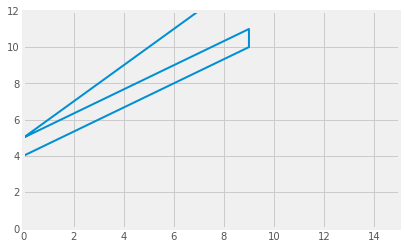

In [118]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

from matplotlib import animation, rc
from IPython.display import HTML

# First set up the figure, the axis, and the plot element we want to animate
fig, ax = plt.subplots()
x_limit = [dronec[i][0] for i in range(len(dronec))]
y_limit = [dronec[i][1] for i in range(len(dronec))]
ax.set_xlim((0,max(x_limit)+3))
ax.set_ylim((0,max(y_limit)+3))

line, = ax.plot([], [], lw=2)

# initialization function: plot the background of each frame
def init():
    line.set_data([], [])
    return (line,)
# animation function. This is called sequentially
def animate(i):
    x = np.array(x_limit)

    y = np.array(y_limit)
    line.set_data(y, x)
    return (line,)
# call the animator. blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=1000, interval=1, blit=True)
HTML(anim.to_html5_video())

30 2
1 2
4 5


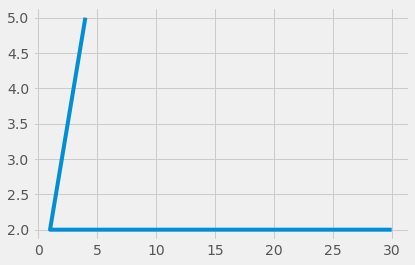

In [95]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import style

style.use('fivethirtyeight')

fig = plt.figure()
ax1 = fig.add_subplot(1,1,1)
z=[[30,2],[1,2],[4,5]]
def animate(i):
    #graph_data = open('example.txt','r').read()
    lines = z#graph_data.split('\n')
    xs = []
    ys = []
    for line in lines:
        if len(line) > 1:
            x, y = line[0],line[1]
            print(x,y)
            xs.append(float(x))
            ys.append(float(y))
    ax1.clear()
    ax1.plot(xs, ys)
ani = animation.FuncAnimation(fig, animate, interval=1000000)
plt.show()

In [21]:
import numpy as np
import matplotlib.pyplot as plt
print(tankc)
x1 = [tankc[i][0] for i in range(len(tankc))]
y1 = [tankc[i][1] for i in range(len(tankc))]

x2 = [tankrc[i][0] for i in range(len(tankrc))]
y2 = [tankrc[i][1] for i in range(len(tankrc))]

x3 = [tankfc[i][0] for i in range(len(tankfc))]
y3 = [tankfc[i][1] for i in range(len(tankfc))]



# plt.scatter(y3,x3,color='black')
# plt.scatter(y2,x2,color='red')
# plt.scatter(y1,x1)
# plt.show

[(13, 2), (6, 0), (13, 4), (6, 0), (13, 6), (13, 8), (6, 1), (13, 10), (13, 12), (12, 15), (10, 12), (6, 3), (6, 3), (6, 4), (6, 4), (6, 4), (10, 1), (6, 4), (6, 4), (6, 6), (11, 1), (12, 1), (6, 7), (6, 7), (6, 7), (13, 4), (6, 7), (13, 6), (6, 8), (13, 14), (6, 9), (6, 9), (11, 16), (6, 9), (6, 10), (10, 11), (9, 12), (11, 1), (13, 0), (13, 2), (13, 4), (6, 12), (13, 6), (6, 12), (13, 8), (13, 2), (12, 5), (6, 14), (13, 6), (13, 8), (6, 14)]


[(13, 4), (13, 3), (13, 5), (13, 6), (13, 7), (13, 9), (13, 11), (13, 11), (13, 14), (10, 11), (10, 5), (10, 3), (10, 4), (13, 9), (12, 9), (13, 11), (6, 10), (13, 13), (13, 15), (13, 16), (11, 16), (11, 15), (10, 16), (10, 13), (10, 13), (10, 14), (10, 11), (11, 1), (13, 1), (13, 4), (13, 3), (13, 5), (13, 6), (13, 7), (13, 8), (13, 9), (13, 11), (13, 11), (13, 14), (13, 15), (6, 15), (10, 8), (10, 7), (10, 6), (10, 5), (10, 3), (10, 4), (10, 2), (11, 1), (13, 6), (13, 7), (13, 8), (13, 11)]


<function matplotlib.pyplot.show(*args, **kw)>

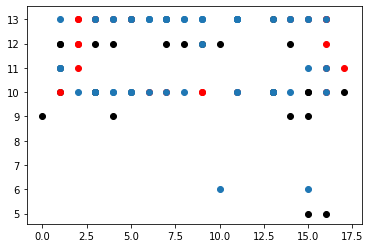

In [20]:
import numpy as np
import matplotlib.pyplot as plt
print(dronec)
x1 = [dronec[i][0] for i in range(len(dronec))]
y1 = [dronec[i][1] for i in range(len(dronec))]

x2 = [dronerc[i][0] for i in range(len(dronerc))]
y2 = [dronerc[i][1] for i in range(len(dronerc))]

x3 = [dronefc[i][0] for i in range(len(dronefc))]
y3 = [dronefc[i][1] for i in range(len(dronefc))]



plt.scatter(y3,x3,color='black')
plt.scatter(y2,x2,color='red')
plt.scatter(y1,x1)
plt.show

In [6]:
import sys
np.set_printoptions(threshold=np.inf)
np.set_printoptions(precision=4)
np.set_printoptions(suppress=True)   

from PIL import  Image,ImageDraw

img = uframes[20]
z = Image.fromarray(img)
z.show()
data3=[]
data3.append(np.array(np.transpose(np.asarray(img),(2,0,1)),dtype=np.float32))
y3 = np.array(data3)
x_1 = torch.from_numpy(y3)
temp = model(x_1[0].reshape(1,3,100,100))[0].detach().numpy()
filename = "Marginalization_Simple-increased_channels-32-video-multiple/TD.txt"
file = open(filename, 'w')
file.write(str(model(x_1[0].reshape(1,3,100, 100))[0].detach().numpy()))
file.close()

In [14]:
import sys
np.set_printoptions(threshold=np.inf)
np.set_printoptions(precision=4)
np.set_printoptions(suppress=True)   

from PIL import  Image,ImageDraw

img = Image.open("frame/tank_frame0.jpg")
img =  cv2.resize(np.asarray(img),(100,100))
data3=[]
data3.append(np.array(np.transpose(np.asarray(img),(2,0,1)),dtype=np.float32))
y3 = np.array(data3)
x_1 = torch.from_numpy(y3)
temp = model(x_1[0].reshape(1,3,100,100))[0].detach().numpy()
filename = "Marginalization_Simple-increased_channels-32-video-multiple/tank.txt"
file = open(filename, 'w')
file.write(str(model(x_1[0].reshape(1,3,100, 100))[0].detach().numpy()))
file.close()

100%|██████████| 1000/1000 [00:03<00:00, 296.44it/s]


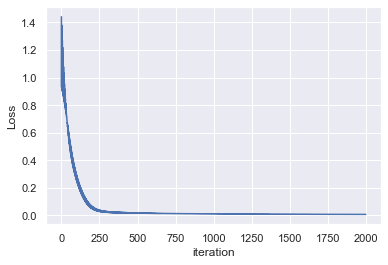

seq 0, prev = tensor([[ 4., 11.]])  -> predicted 5th step = tensor([[ 4.0181, 10.1336]]), actual step = tensor([[ 4., 10.]])
		predicted step 6 (prev = tensor([[[ 4., 10.]]])) = tensor([[3.8167, 8.9214]]), actual step = tensor([[4., 9.]])
		predicted step 7 (prev = tensor([[[4., 9.]]])) = tensor([[3.7085, 7.7733]]), actual step = tensor([[4., 8.]])
		predicted step 8 (prev = tensor([[[4., 8.]]])) = tensor([[3.6956, 6.6876]]), actual step = tensor([[4., 7.]])
		predicted step 9 (prev = tensor([[[4., 7.]]])) = tensor([[3.7559, 5.6683]]), actual step = tensor([[4., 6.]])
		predicted step 10 (prev = tensor([[[4., 6.]]])) = tensor([[3.8623, 4.7333]]), actual step = tensor([[4., 5.]])
		predicted step 11 (prev = tensor([[[4., 5.]]])) = tensor([[3.9918, 3.9030]]), actual step = tensor([[4., 4.]])
		predicted step 12 (prev = tensor([[[4., 4.]]])) = tensor([[4.1273, 3.1905]]), actual step = tensor([[4., 3.]])
		predicted step 13 (prev = tensor([[[4., 3.]]])) = tensor([[4.2568, 2.5978]]), actual

In [53]:
import seaborn as sns
from tqdm import trange
sns.set()

class MyRnn(nn.Module):
  def __init__(self, in_d=2, out_d=2, hidden_d=4, num_hidden=1):
    super(MyRnn, self).__init__()
    self.rnn = nn.RNN(input_size=in_d, hidden_size=hidden_d, num_layers=num_hidden)
    self.fc = nn.Linear(hidden_d, out_d)

  def forward(self, x, h0):
    r, h = self.rnn(x, h0)
    y = self.fc(r)  # no activation on the output
    return y, h

s1 = torch.tensor([[4, 15], [4, 14], [4, 13], [4, 12], [4, 11], [4, 10], [4, 9], [4, 8], [4,7], [4, 6], [4, 5], [4, 4], [4, 3], [4, 2]], dtype=torch.float)[:, None, :] 
s2 = torch.tensor([[4, 15], [5,15],[6,15],[7,15],[8,15],[9,15],[10,15],[11, 15],[12, 15],[12,14],[12,13],[12,12],[12,11],[12,10],[12,9],[12,8],[12,7],[12,6],[12,5]],dtype=torch.float)[:, None, :]

x = torch.cat((s1,s2),dim=0)
mu = x.mean(dim=0)
sig=x.std(dim=0)
sequences = [(s1-mu)/sig, (s2-mu)/sig]  # pythonic list to hold sequences of un-even length

in_d = s1.shape[-1]
out_d = in_d
hidden_d = 8
num_hidden = 1
rnn = MyRnn(in_d, out_d, hidden_d, num_hidden)
loss = []
criterion = nn.MSELoss()
opt = torch.optim.SGD(rnn.parameters(), lr=0.01)
n_epochs = 1000
for e in trange(n_epochs):
  for s in sequences:
    pred, _ = rnn(s[:-1,...], torch.zeros(num_hidden, 1, hidden_d, dtype=torch.float))  # predict next step, init hidden state to zero at the begining of the sequence
    err = criterion(pred, s[1:, ...])  # predict next step for each step
    opt.zero_grad()
    err.backward()
    opt.step()
    loss.append(err.item())
plt.plot(loss)
plt.ylabel('Loss')
plt.xlabel('iteration')
plt.show()

rnn.eval()
with torch.no_grad():
  k = 5 
  for si, s in enumerate(sequences):
    pred, h = rnn(s[:k,...], torch.zeros(num_hidden, 1, hidden_d, dtype=torch.float))  # given first k steps predict the next one
    print('seq {}, prev = {}  -> predicted {}th step = {}, actual step = {}'.format(si, s[k-1,...]*sig+mu, k, pred[-1, ...]*sig + mu, s[k, ...]*sig+mu))
    prev = (torch.round(pred[-1:, ...]*sig + mu) - mu) / sig  # round the prediction, attmepting to avoid accumulation of error
    # continue to predict 
    for j in  range(k+1, s.shape[0]):
      pred, h = rnn(prev, h)
      print('\t\tpredicted step {} (prev = {}) = {}, actual step = {}'.format(j, prev*sig+mu, pred[-1,...]*sig+mu, s[j, ...]*sig + mu))
      prev = (torch.round(pred*sig + mu) - mu) / sig
  print('\n')